In [1]:
import arviz as az
from pathlib import Path

In [2]:
from vangja.data_utils import (
    download_data,
    generate_train_test_df_around_point,
    process_data,
)

In [3]:
dfs = download_data(Path("./data"))
indexes = process_data(dfs[0])
smp = [index for index in indexes if index["series"].iloc[0] == "^GSPC"]
gspc_tickers = process_data(dfs[1])

In [4]:
import pandas as pd
point = "2014-01-01"
train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 40, horizon=365 * 1, dfs=smp, for_prophet=False, point=point
)
ds_min = pd.to_datetime(train_df_smp["ds"]).min()
ds_max = pd.to_datetime(train_df_smp["ds"]).max()

Output()

/home/jovan/repos/test/magisterska/vangja_simple/components/linear_trend.py:213: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


        mse      rmse       mae     mape
y  0.038816  0.197017  0.187642  0.15925


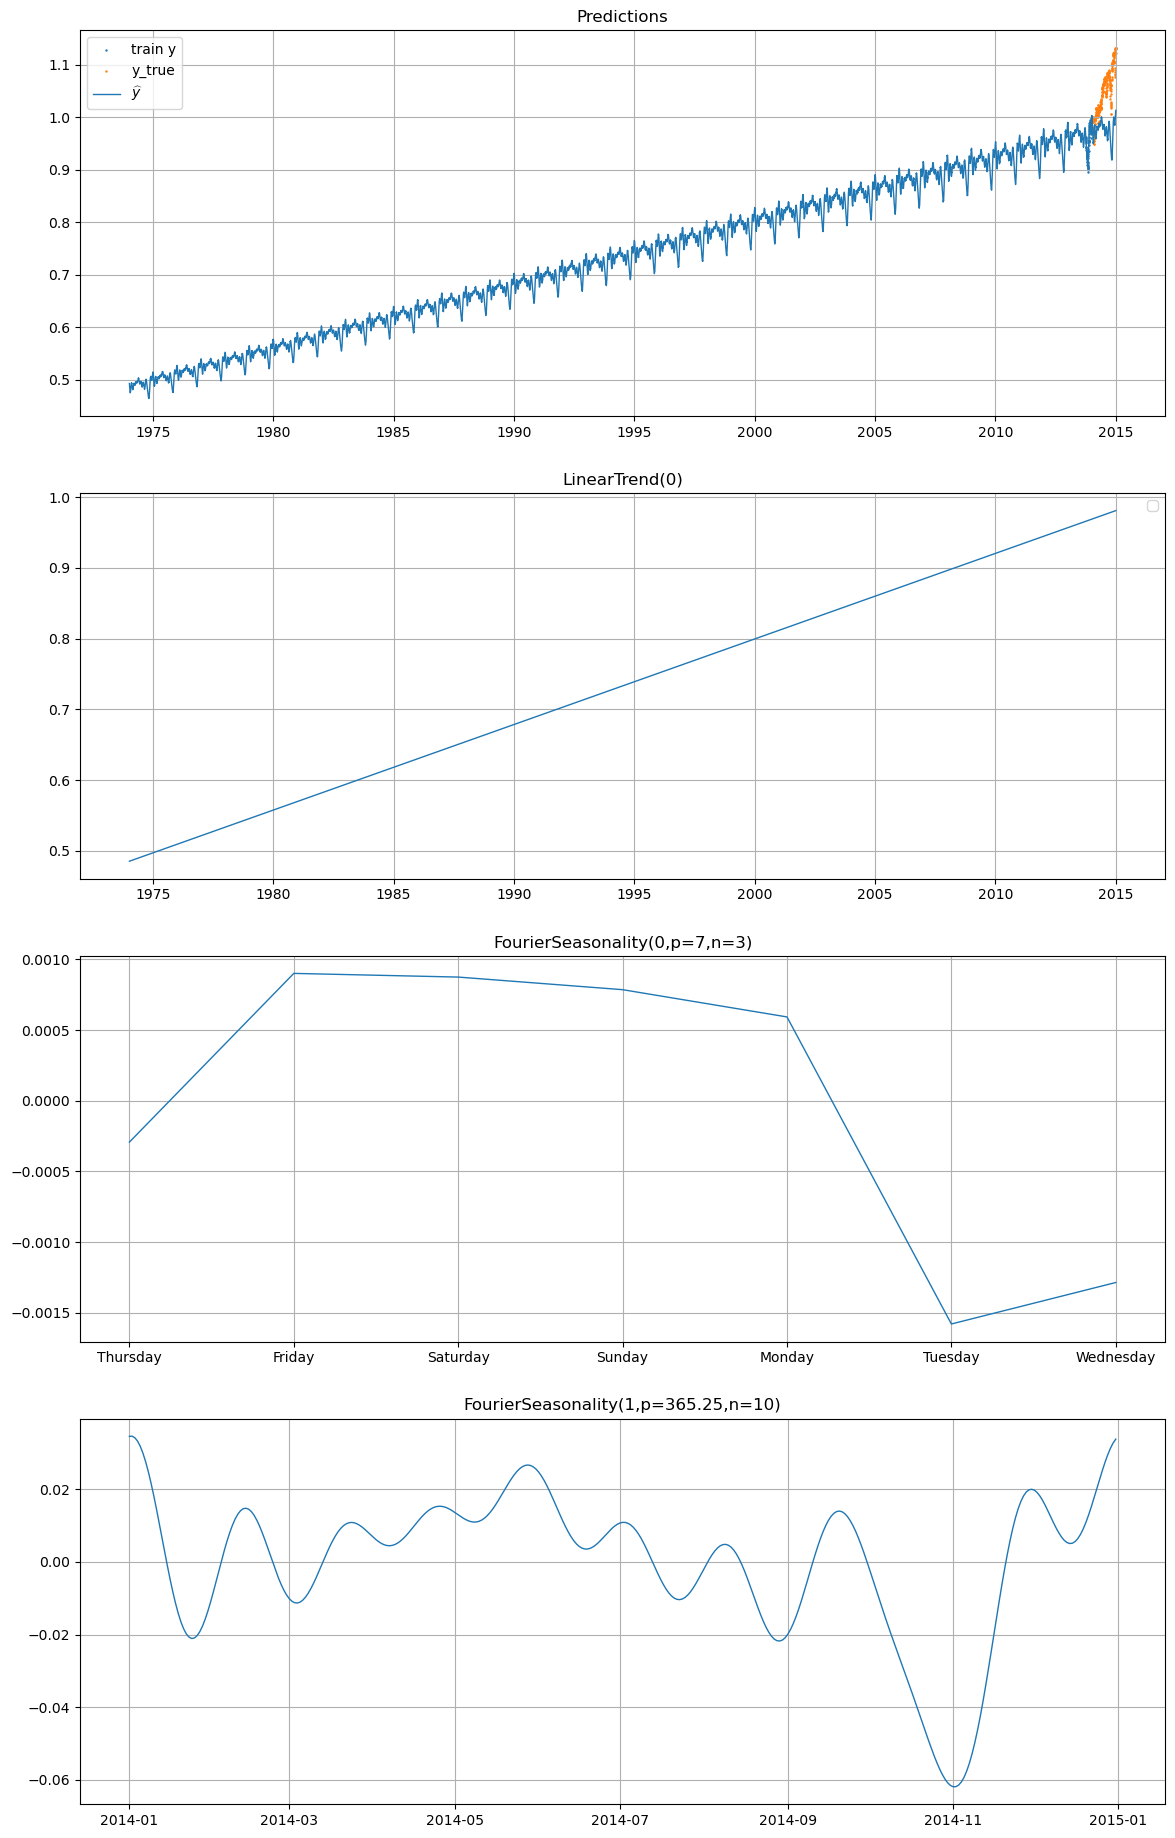

In [24]:
from vangja_simple.components import LinearTrend, FourierSeasonality

check = generate_train_test_df_around_point(
        window=91,
        horizon=365,
        dfs=[gspc_tickers[0]],
        for_prophet=False,
        point=point,
    )

train_df_tickers, test_df_tickers, scales_tickers = check

trend = LinearTrend(changepoint_range=1)
decenial = FourierSeasonality(365.25 * 10, 4, allow_tune=True, tune_method="simple")
presidential = FourierSeasonality(365.25 * 4, 9, allow_tune=True, tune_method="simple")
yearly = FourierSeasonality(365.25, 10, allow_tune=True, tune_method="simple")
weekly = FourierSeasonality(7, 3, allow_tune=True, tune_method="simple")
model = trend ** (weekly + yearly)
model.load_model(Path("./") / "models" / "advi_40_y_w")

model.tune(train_df_tickers)
yhat = model.predict(365)
model.plot(yhat, test_df_smp)
print(model.metrics(test_df_tickers, yhat))

In [10]:
yhat

,ds,t,lt_0,fs_0,fs_1,yhat
0,1974-01-11,0.000000,0.564970,0.000823,-0.134367,0.489522
1,1974-01-12,0.000068,0.565009,0.000745,-0.138823,0.486993
2,1974-01-13,0.000137,0.565047,0.000707,-0.143474,0.484377
3,1974-01-14,0.000205,0.565086,0.000602,-0.148252,0.481651
4,1974-01-15,0.000274,0.565125,-0.001296,-0.153086,0.477880
...,...,...,...,...,...,...
14960,2014-12-27,1.024728,1.141429,0.000745,-0.117073,1.008649
14961,2014-12-28,1.024796,1.141467,0.000707,-0.115314,1.010648
14962,2014-12-29,1.024865,1.141506,0.000602,-0.113811,1.012277
14963,2014-12-30,1.024933,1.141545,-0.001296,-0.112621,1.011503


In [7]:
print(model.metrics(test_df_smp, yhat))

        mse      rmse      mae      mape
y  0.005699  0.075493  0.06362  0.060961


In [8]:
model.trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Output()

/home/jovan/repos/test/magisterska/vangja_simple/components/linear_trend.py:222: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


       mse     rmse      mae      mape
y  0.00383  0.06189  0.05497  0.052789


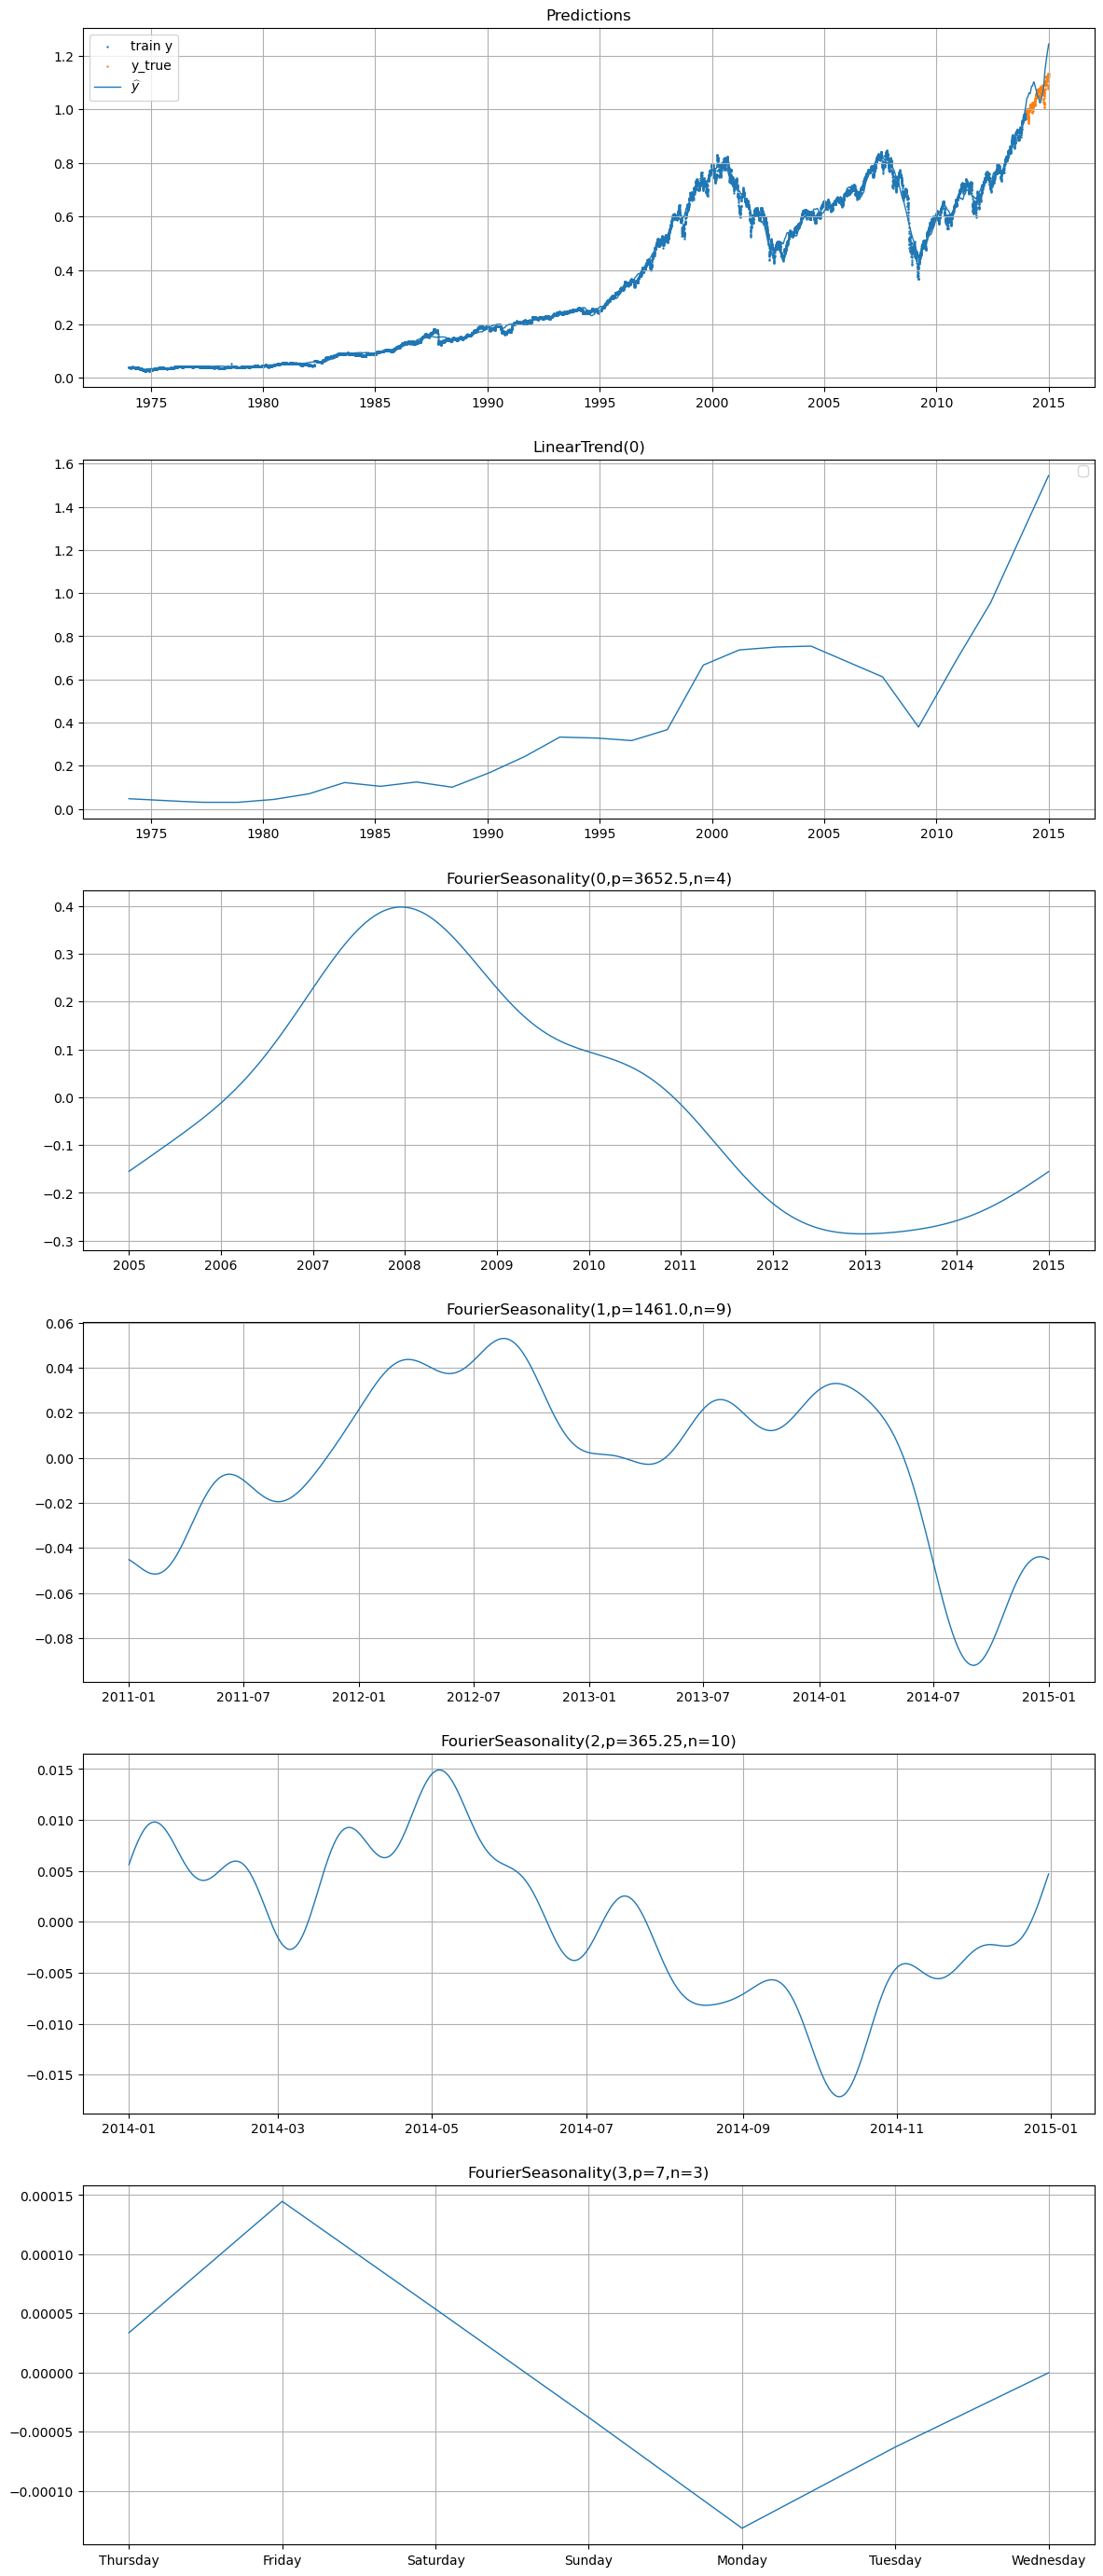

In [34]:
trend = LinearTrend(changepoint_range=1)
decenial = FourierSeasonality(365.25 * 10, 4, allow_tune=True, tune_method="simple")
presidential = FourierSeasonality(365.25 * 4, 9, allow_tune=True, tune_method="simple")
yearly = FourierSeasonality(365.25, 10, allow_tune=True, tune_method="simple")
weekly = FourierSeasonality(7, 3, allow_tune=True, tune_method="simple")
model = trend ** (decenial + presidential + yearly + weekly)
model.fit(train_df_smp)
yhat = model.predict(365 * 1)
model.plot(yhat, test_df_smp)
print(model.metrics(test_df_smp, yhat))
# model.save_model(Path("./") / "models" / "40_d_p_y_w")

In [37]:
initvals = model._get_model_initvals()
initval_dict = model.get_initval(initvals, model.model)
initval_dict

{sigma ~ HalfNormal(0, 0.5): 1.0,
 lt_0 - slope ~ Normal(0, 5): 0.9620768208633255,
 lt_0 - intercept ~ Normal(0, 5): 0.03792317913667448,
 lt_0 - delta ~ Laplace(0, 0.05): array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])}

In [39]:
import pymc as pm
import pymc_extras as pmx

with model.model:
    map_approx = pmx.find_MAP(
        "L-BFGS-B",
        use_grad=True,
        initvals=initval_dict,
        gradient_backend="jax",
        compile_kwargs={"mode": "JAX"},
        options={"maxiter": 1e4},
    )
    print(map_approx)
    approx = pmx.fit_laplace(
        "L-BFGS-B",
        use_grad=True,
        initvals=initval_dict,
        chains=4,
        draws=1000,
        gradient_backend="jax",
        compile_kwargs={"mode": "JAX"},
        optimizer_kwargs={
            "options": {"maxiter": 1e4},
        },
    )

Output()

{'lt_0 - slope': array(-0.21863638), 'lt_0 - intercept': array(0.04729848), 'lt_0 - delta': array([ 2.44096911e-02,  1.80612758e-01,  3.36076885e-01,  3.31520853e-01,
        6.73397846e-01, -1.77093426e+00,  9.55806262e-01, -1.13141609e+00,
        2.22771057e+00,  2.81199642e-01,  4.29325074e-01, -2.42112700e+00,
       -2.14430623e-01,  1.57404727e+00,  6.23306346e+00, -5.72631245e+00,
       -1.43394882e+00, -2.08759636e-01, -1.90212461e+00, -1.34834495e-02,
       -4.02034924e+00,  1.31821860e+01, -4.13493220e-01,  2.16193737e+00,
        1.25718620e-04]), 'fs_0 - beta(p=3652.5,n=4)': array([-0.27308717,  0.14254207, -0.01203701, -0.03455359,  0.04019125,
       -0.01756174,  0.02047564,  0.00449126]), 'fs_1 - beta(p=1461.0,n=9)': array([-0.03700291, -0.00791736,  0.00319458,  0.02457341, -0.0032913 ,
        0.01703766,  0.00876849,  0.00025191,  0.00678147, -0.00435145,
        0.00741456, -0.00081986, -0.0026435 , -0.00601316, -0.00135815,
        0.00200499,  0.00051816,  0.00

Output()

ValueError: different number of dimensions on data and dims: 3 vs 2

In [40]:
import pymc as pm
with model.model:
    approx_lr = pm.fit(n=50000, method="fullrank_advi", start=initval_dict)

Output()

Finished [100%]: Average Loss = -20,319


In [41]:
trace = approx_lr.sample(draws=10000)

In [42]:
import arviz as az
az.summary(trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lt_0 - slope,0.721,0.998,-1.069,2.648,0.010,0.007,9509.0,9124.0,NaN
lt_0 - intercept,-0.010,0.066,-0.133,0.111,0.001,0.000,9652.0,9763.0,NaN
lt_0 - delta[0],-0.236,0.901,-1.934,1.451,0.009,0.006,10074.0,9775.0,NaN
lt_0 - delta[1],-0.168,1.000,-2.069,1.653,0.010,0.007,9454.0,9306.0,NaN
lt_0 - delta[2],-0.080,1.017,-1.939,1.873,0.010,0.008,9498.0,8892.0,NaN
...,...,...,...,...,...,...,...,...,...
"fs_3 - beta(p=7,n=3)[2]",0.001,0.013,-0.023,0.026,0.000,0.000,9751.0,9836.0,NaN
"fs_3 - beta(p=7,n=3)[3]",-0.002,0.013,-0.025,0.022,0.000,0.000,9862.0,10003.0,NaN
"fs_3 - beta(p=7,n=3)[4]",-0.001,0.014,-0.029,0.025,0.000,0.000,9788.0,9647.0,NaN
"fs_3 - beta(p=7,n=3)[5]",0.000,0.015,-0.028,0.027,0.000,0.000,10129.0,9876.0,NaN


In [43]:
model.trace = trace
model.fit_params["trace"] = trace

/home/jovan/repos/test/magisterska/vangja_simple/components/linear_trend.py:222: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


       mse     rmse      mae      mape
y  0.00383  0.06189  0.05497  0.052789


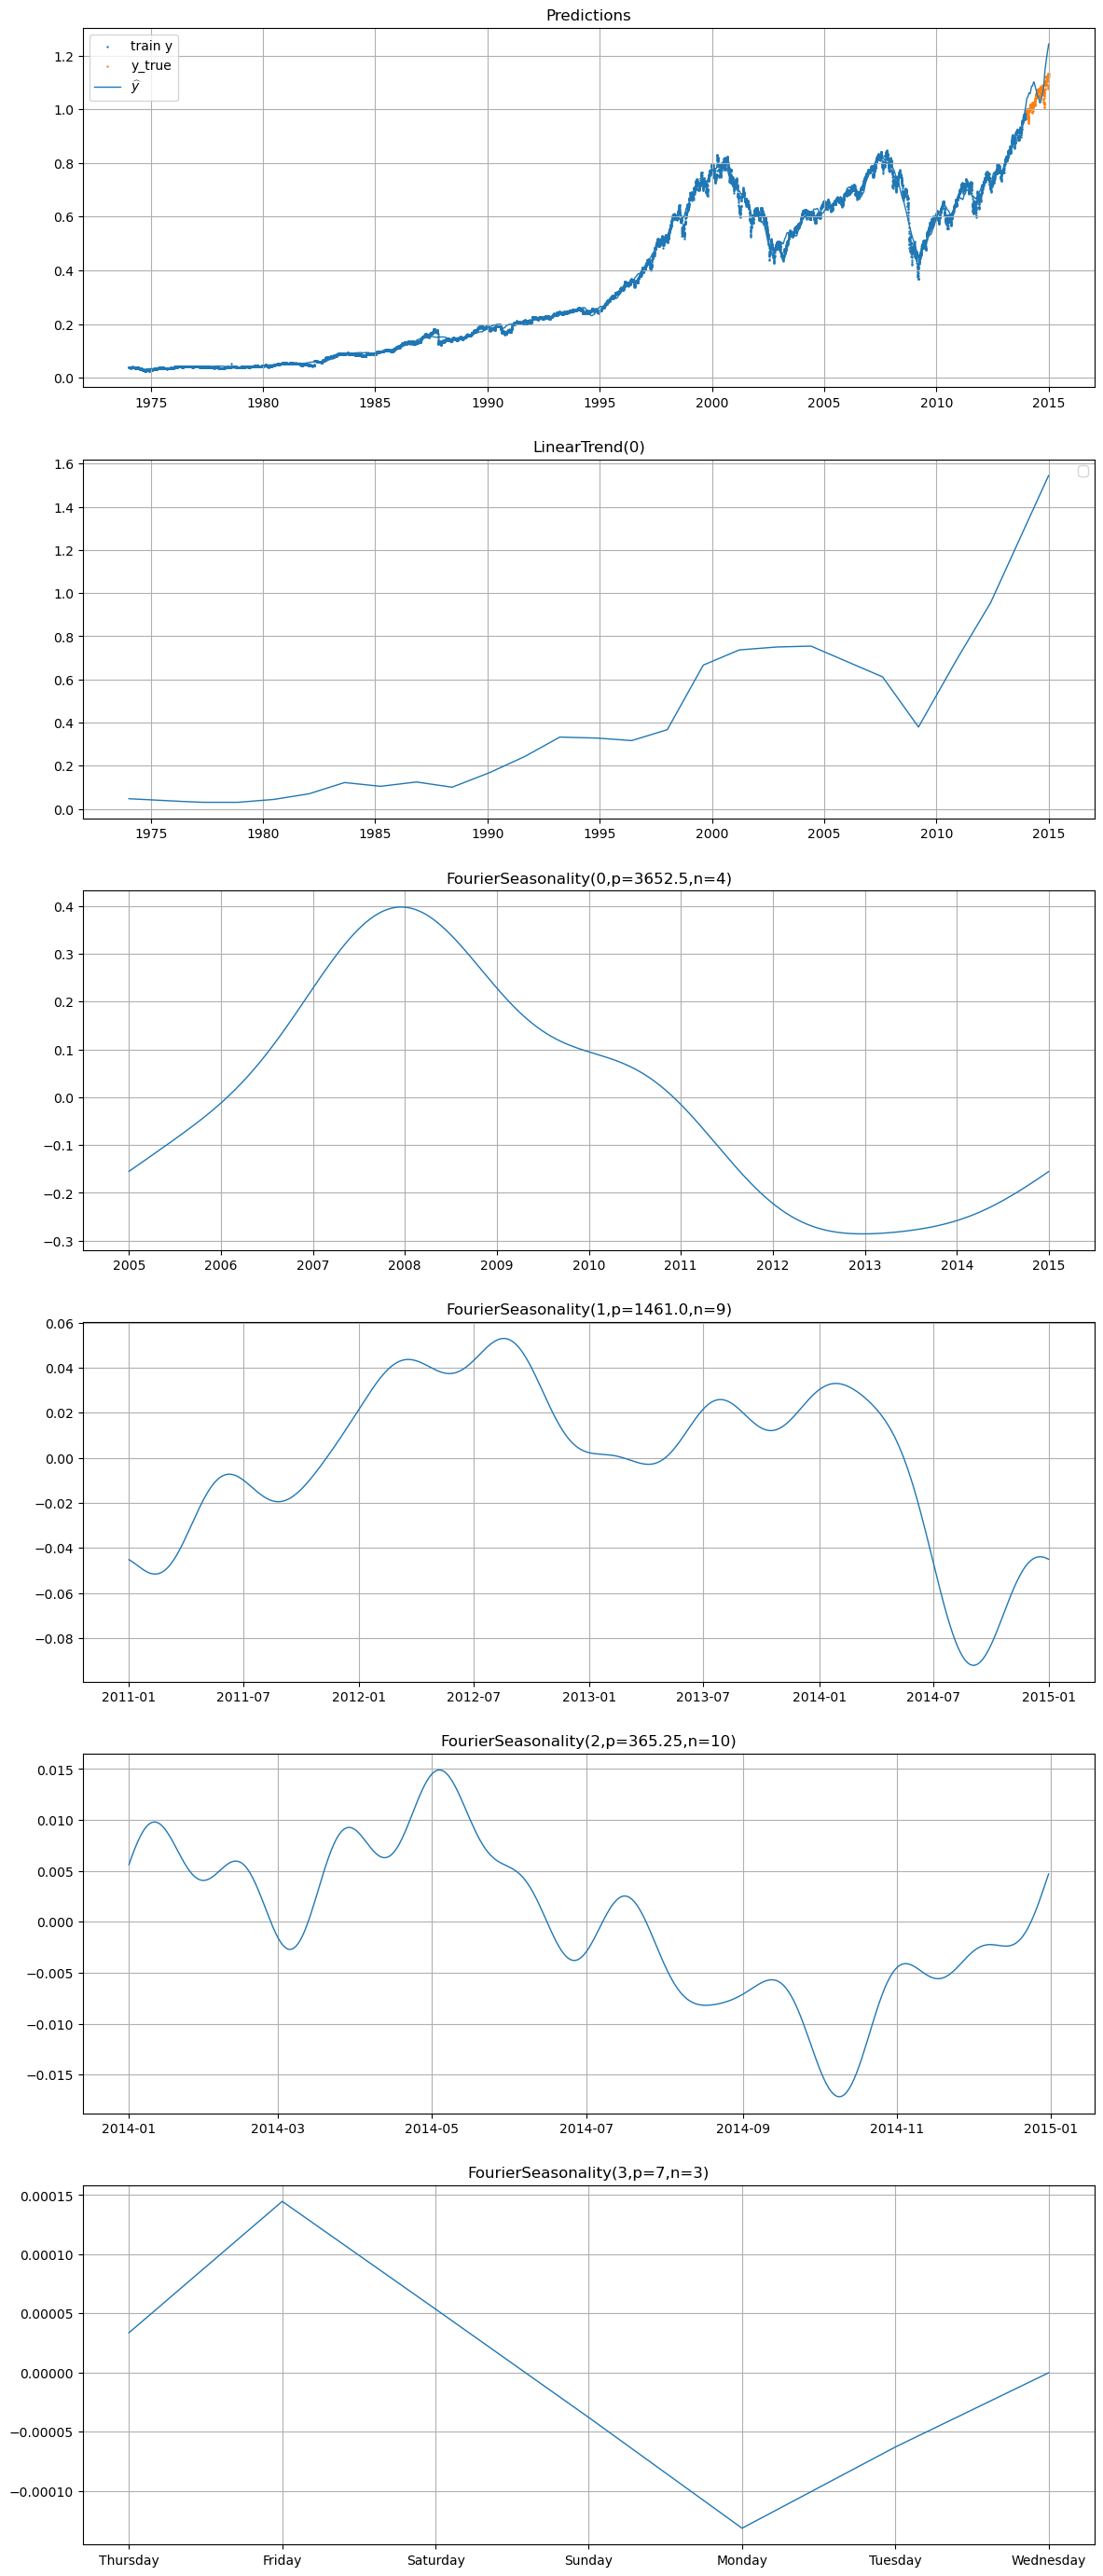

In [44]:
yhat = model.predict(365 * 1)
model.plot(yhat, test_df_smp)
print(model.metrics(test_df_smp, yhat))

In [17]:
trace["posterior"]["fs_3 - beta(p=7,n=3)"].shape

(1, 500, 6)

In [13]:
check = generate_train_test_df_around_point(
    window=91, horizon=365, dfs=[gspc_tickers[0]], for_prophet=False, point="2015-01-01"
)

train_df_tickers, test_df_tickers, scales_tickers = check
model.tune(train_df_tickers, ds_min=None, ds_max=None, progressbar=False)
yhat = model.predict(365)
model_metrics = model.metrics(
    test_df_tickers, yhat, label=train_df_tickers["series"].iloc[0]
)
print(model_metrics["mape"].iloc[0])

8.50758270600996


/home/jovan/repos/test/magisterska/vangja_simple/components/linear_trend.py:222: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


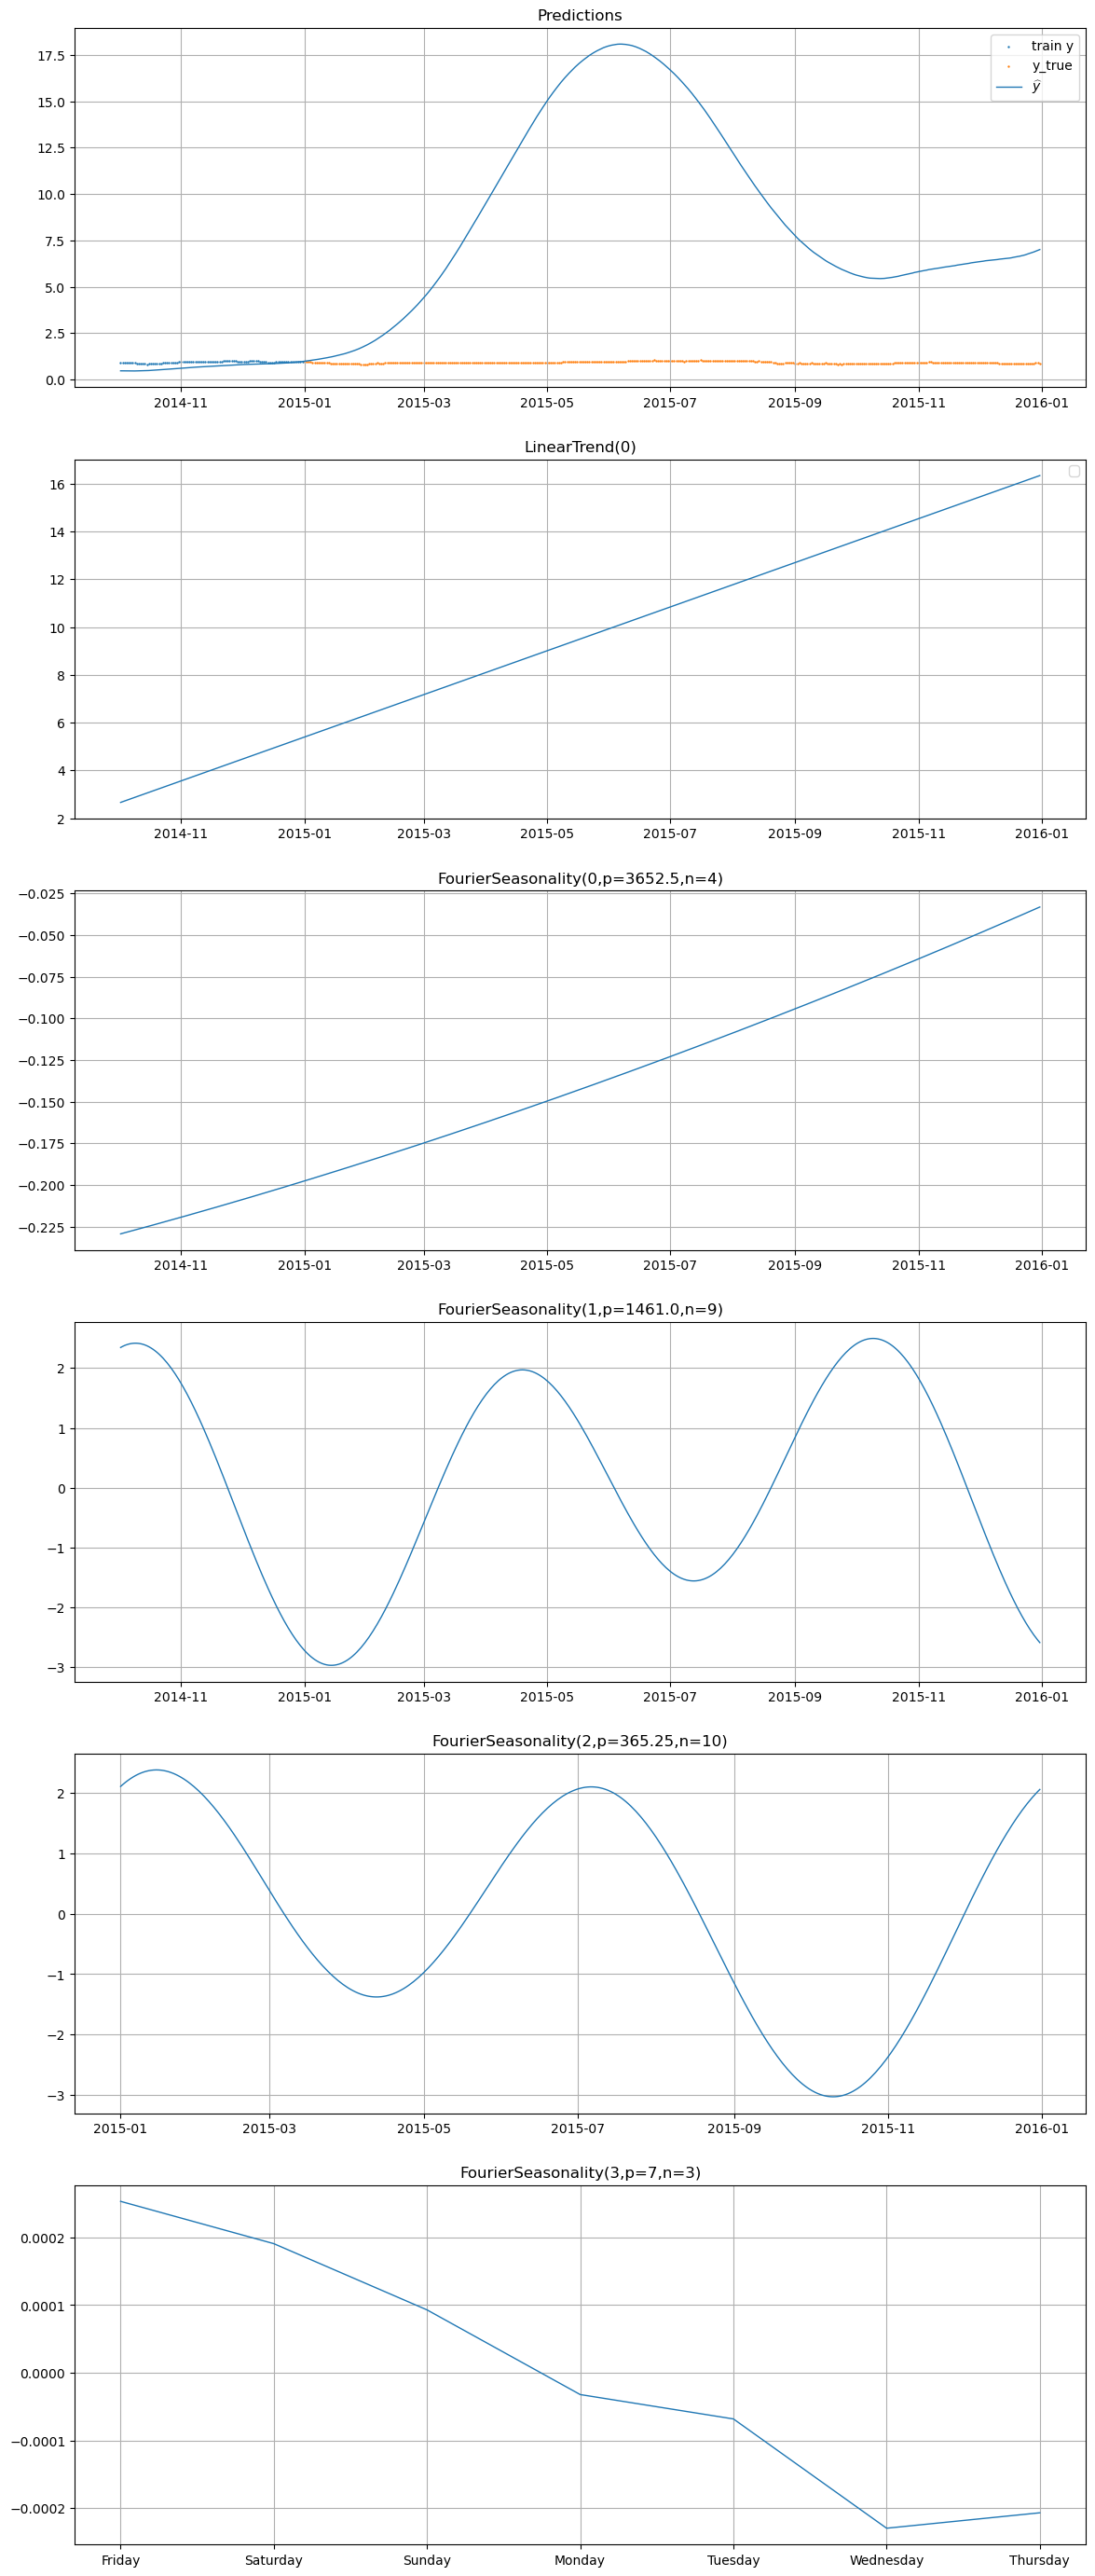

In [14]:
model.plot(yhat, test_df_tickers)

In [11]:
trace = az.from_netcdf(Path("./") / "models" / "40_y10_w.nc")
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [21]:
(
    trace["posterior"]["fs_0 - beta(p=365.25,n=10)"].to_numpy().mean(axis=(1, 0)),
    trace["posterior"]["fs_0 - beta(p=365.25,n=10)"].to_numpy().std(axis=(1, 0)),
)

(array([ 1.36541446e-02, -1.62969781e-03, -3.54467726e-03,  4.97667533e-03,
        -8.58690302e-04,  3.81346912e-03,  1.59133316e-03,  1.35787803e-05,
        -4.68314704e-04, -1.14433551e-03,  1.70492600e-03,  6.75020257e-04,
        -1.88636465e-03,  1.00355127e-03, -9.39081443e-04,  4.77339132e-05,
         3.92412075e-04,  1.17751514e-03,  1.99940692e-03, -7.43194270e-04]),
 array([0.00058284, 0.0005868 , 0.00058   , 0.00056681, 0.0005825 ,
        0.00060312, 0.00057107, 0.00058547, 0.00058   , 0.00058128,
        0.00059432, 0.00058552, 0.00059893, 0.00057243, 0.00056806,
        0.00058903, 0.00057379, 0.00058281, 0.00060021, 0.000585  ]))

In [22]:
(
    model.fit_params["trace"]["posterior"]["fs_1 - beta(p=365.25,n=10)"]
    .to_numpy()
    .mean(axis=(1, 0)),
    model.fit_params["trace"]["posterior"]["fs_1 - beta(p=365.25,n=10)"]
    .to_numpy()
    .std(axis=(1, 0)),
)

(array([-6.51963662e-03, -3.30429311e-02, -1.01434906e-02, -2.12729450e-02,
        -7.50848529e-04,  4.23745908e-03,  1.90182313e-03,  6.99482195e-04,
        -1.51570587e-03, -2.00031158e-03,  1.30260302e-03, -7.28471270e-04,
        -2.07334669e-03,  4.55348927e-04, -1.21093873e-03, -4.62675464e-04,
        -2.52444533e-04,  1.61105490e-03,  2.68228288e-03,  1.74601176e-06]),
 array([0.79450785, 0.80647921, 0.78705016, 0.82899155, 0.0061247 ,
        0.00760612, 0.00656694, 0.00892066, 0.0075355 , 0.007075  ,
        0.00787118, 0.00800535, 0.00804341, 0.00927978, 0.00842027,
        0.00964903, 0.00852722, 0.00920167, 0.00913859, 0.00874713]))

In [7]:
trace["posterior"]["fs_0 - beta(p=3652.5,n=4)"].to_numpy().std(axis=(0,1))

array([0.00979837, 0.00579001, 0.00199108, 0.00461125, 0.00192773,
       0.00142779, 0.0012093 , 0.00070278])

In [16]:
import numpy as np
stds = []
for k in range(20):
    stds.append(trace["posterior"]["fs_0 - beta(p=365.25,n=10)"].to_numpy()[:, :, k].std())

np.array(stds) - trace["posterior"]["fs_0 - beta(p=365.25,n=10)"].to_numpy().std(axis=(0,1))

array([-6.50521303e-19,  2.16840434e-19,  4.33680869e-19, -6.50521303e-19,
       -2.16840434e-19, -8.67361738e-19,  3.25260652e-19, -3.25260652e-19,
       -5.42101086e-19,  7.58941521e-19,  1.08420217e-19,  5.42101086e-19,
        4.33680869e-19,  1.08420217e-18,  2.16840434e-19,  2.16840434e-19,
        2.16840434e-19, -2.16840434e-19,  2.16840434e-19,  5.42101086e-19])

In [9]:
trace["posterior"]["fs_0 - beta(p=365.25,n=10)"].to_numpy().std(axis=(1, 0))

array([0.00026623, 0.00026327, 0.00025478, 0.00025844, 0.0002704 ,
       0.00026999, 0.00026516, 0.00026919, 0.00025538, 0.00027118,
       0.00027061, 0.00026019, 0.00026539, 0.00026639, 0.0002709 ,
       0.00026203, 0.00026664, 0.00026187, 0.00026388, 0.00026198])

In [33]:
trace["posterior"]["fs_1 - beta(p=7,n=3)"].to_numpy().std(axis=1).mean(axis=0)

array([ 9.06452274,  9.06193701,  8.89914216,  7.60633643,  8.70338861,
       10.72171237])

In [1]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd

from vangja_simple.components import LinearTrend, FourierSeasonality, BetaConstant
from vangja.data_utils import (
    generate_train_test_df_around_point,
    download_data,
    process_data,
)

print("Downloading data...")
dfs = download_data(Path("./data"))
indexes = process_data(dfs[0])
smp = [index for index in indexes if index["series"].iloc[0] == "^GSPC"]
gspc_tickers = process_data(dfs[1])
print("Data downloaded!")

Data downloaded!


In [3]:
from vangja_simple.components import Constant
from vangja_simple.components.normal_constant import NormalConstant

from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
)


def train_metrics(y_true, future, label="y"):
    y = y_true["y"]
    yhat = future["yhat"][:len(y)]
    return pd.DataFrame(
        {
            "mse": {f"{label}": mean_squared_error(y, yhat)},
            "rmse": {f"{label}": root_mean_squared_error(y, yhat)},
            "mae": {f"{label}": mean_absolute_error(y, yhat)},
            "mape": {f"{label}": mean_absolute_percentage_error(y, yhat)},
        }
    )

trend = LinearTrend(changepoint_range=1)
yearly = FourierSeasonality(365.25, 10, allow_tune=True, tune_method="simple")
weekly = FourierSeasonality(7, 3, allow_tune=False, tune_method="simple")
model =  trend ** (yearly + weekly)

point = "2014-01-01"

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 40, horizon=365, dfs=smp, for_prophet=False, point=point
)

# model.fit(train_df_smp, mcmc_samples=0, nuts_sampler="numpyro")
model.load_trace(Path("./") / "models" / "40_y10_w.nc")
# model.fit_params["trace"].to_netcdf(Path("./") / "models" / "109.nc")
# yhat = model.predict(365)
# print(model.metrics(test_df_smp, yhat)["mape"].iloc[0])

model_metrics = []
point = "2014-01-01"
trend.changepoint_range = 0.8
yearly.beta_sd = 0.001
fit_params = model.fit_params

model_positive = trend ** (yearly + weekly)
model_positive.fit_params = fit_params
model_positive.tuned_model = None

model_negative = trend ** (NormalConstant(mu=-1, sd=0.1) * yearly + weekly)
model_negative.fit_params = fit_params
model_negative.tuned_model = None

am_i_right_positive = 0
am_i_right_negative = 0
positive = 0
negative = 0

for idx, gspc_ticker in enumerate(gspc_tickers):
    check = generate_train_test_df_around_point(
        window=91,
        horizon=365,
        dfs=[gspc_ticker],
        for_prophet=False,
        point=point,
    )

    if check is None:
        continue

    train_df_tickers, test_df_tickers, scales_tickers = check
    model_positive.tune(train_df_tickers, progressbar=False)
    # model_negative.tune(train_df_tickers, progressbar=False)
    yhat_positive = model_positive.predict(365)
    # yhat_negative = model_negative.predict(365)
    train_positive_metrics = train_metrics(train_df_tickers, yhat_positive, train_df_tickers.iloc[0]["series"])
    # train_negative_metrics = train_metrics(train_df_tickers, yhat_negative, train_df_tickers.iloc[0]["series"])
    test_positive_metrics = model.metrics(test_df_tickers, yhat_positive, train_df_tickers.iloc[0]["series"])
    # test_negative_metrics = model.metrics(test_df_tickers, yhat_negative, train_df_tickers.iloc[0]["series"])
    # if train_positive_metrics["mape"].iloc[0] <= 2 * train_negative_metrics["mape"].iloc[0]:
    #     positive += 1
    #     model_metrics.append(test_positive_metrics)
    #     if test_positive_metrics["mape"].iloc[0] <= test_negative_metrics["mape"].iloc[0]:
    #         am_i_right_positive += 1
    # else:
    #     negative += 1
    #     model_metrics.append(test_negative_metrics)
    #     if test_positive_metrics["mape"].iloc[0] > test_negative_metrics["mape"].iloc[0]:
    #         am_i_right_negative += 1
    model_metrics.append(test_positive_metrics)
    print(f"{idx}/{len(gspc_tickers)}: {pd.concat(model_metrics)['mape'].mean()}")
    # print(f"tp: {am_i_right_positive}, tn: {am_i_right_negative}, p: {positive}, n: {negative}, acc: {(am_i_right_negative + am_i_right_positive) / (positive + negative)}")

final_metrics = pd.concat(model_metrics)
print(f"{final_metrics['mape'].mean()}")

# trend ** (NormalConstant(mu=1, sd=0.1) * yearly + weeklyF) - 0.29079609709011245
# trend ** (NormalConstant(mu=1, sd=0.1) * yearly + weeklyT) - 0.29135071947776253
# trend ** (yearly + weeklyT) - 0.2891237926259398
# trend ** (yearly + weeklyF) - 


1/503: 0.7227252054919245
2/503: 0.48648131374692516
3/503: 0.49738411468957394
4/503: 0.4095233572093041
5/503: 0.3651601761348501
6/503: 0.36368167929751394
7/503: 0.34418945068765744
8/503: 0.30651476935462824
9/503: 0.29494427515394284
10/503: 0.2842760932780237
11/503: 0.2906670843532692
12/503: 0.2917932868519602
13/503: 0.2777831467610651
14/503: 0.28399231239090833
16/503: 0.28869362677151883
17/503: 0.28045947374524055
18/503: 0.27892539909178804
19/503: 0.2710440591952434
20/503: 0.27611578837577455
21/503: 0.28273878765385163
22/503: 0.2767177805032692
23/503: 0.2906448649434226
24/503: 0.2838373692413616
25/503: 0.28646952988973934
26/503: 0.2829961073032507
27/503: 0.2898087241558299
29/503: 0.2852050232120921
30/503: 0.28562045583482554
31/503: 0.2792336744696462
32/503: 0.28869916363039155
33/503: 0.2823225033988986
35/503: 0.2763485664190214
36/503: 0.28768509963424316
37/503: 0.2831291696179792
38/503: 0.29107700700024525
40/503: 0.29198535597072656
41/503: 0.285353484

In [4]:
final_metrics['mape'].mean()

0.29079609709011245

In [11]:
model_positive.map_approx

{'lt_0 - slope': array(-0.24753293),
 'lt_0 - delta': array([-4.83735077e-07,  7.96986859e-06, -1.06693205e-04, -5.17911079e-03,
        -2.63657907e-05,  4.99349393e-05,  2.77238304e-01,  1.88510229e-01,
        -3.29914568e-05, -2.72296721e-05, -1.94351204e-02, -5.21763866e-02,
        -4.76070625e-02, -6.95206994e-11, -1.83150080e-05, -7.81989218e-05,
         4.92772049e-05, -2.44251797e-02, -9.58417842e-02, -1.32732202e-01,
        -9.53623189e-03, -1.33859409e-05,  3.28871863e-05,  4.87955465e-07,
         2.89664105e-01]),
 'lt_0 - intercept': array(0.98503531),
 'nc_0 - normal(mu=1,sd=0.1)': array(1.03875157),
 'fs_0 - beta(p=365.25,n=10)': array([ 1.36241518e-02, -1.58049709e-03, -3.60991865e-03,  4.88900912e-03,
        -8.22017925e-04,  3.64743272e-03,  1.72166213e-03, -2.07413988e-04,
        -1.42106004e-04, -1.41960881e-03,  2.31295817e-03,  4.46060841e-04,
        -9.67335906e-04,  1.10517087e-03, -9.54874209e-05,  7.19636772e-04,
         7.62180258e-04,  1.99985226e-03

In [12]:
model_negative.map_approx

AttributeError: 'MultiplicativeTimeSeries' object has no attribute 'map_approx'